In [2]:
# imports
import numpy as np
import pandas as pd

# modelling
from sklearn.datasets import load_digits
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split

# Tree Visualization
import matplotlib.pyplot as plt
import seaborn as sn

Dataset split: 1797 train rows 1797 test rows


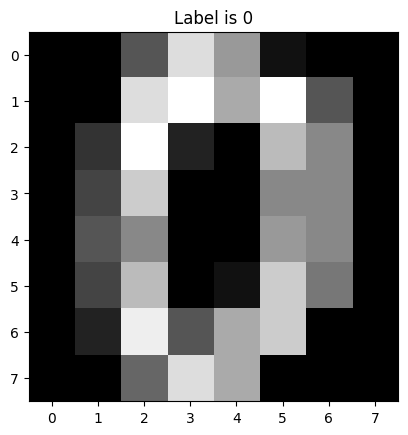

In [3]:
# Initialize
digits = load_digits()
print(f"Dataset split: {len(digits.data)} train rows",
          f"{len(digits.target)} test rows")

point = np.array(digits.images[0], dtype='uint8')
point = point.reshape((8, 8))

plt.title('Label is {label}'.format(label=digits.target[0]))
plt.imshow(point, cmap='gray')
plt.show()

In [18]:
# Add outliers
df = pd.DataFrame()
print(digits.data.shape)
print(digits.data)
print(digits.target)
print(digits.images)

(1797, 64)
[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
[0 1 2 ... 8 9 8]
[[[ 0.  0.  5. ...  1.  0.  0.]
  [ 0.  0. 13. ... 15.  5.  0.]
  [ 0.  3. 15. ... 11.  8.  0.]
  ...
  [ 0.  4. 11. ... 12.  7.  0.]
  [ 0.  2. 14. ... 12.  0.  0.]
  [ 0.  0.  6. ...  0.  0.  0.]]

 [[ 0.  0.  0. ...  5.  0.  0.]
  [ 0.  0.  0. ...  9.  0.  0.]
  [ 0.  0.  3. ...  6.  0.  0.]
  ...
  [ 0.  0.  1. ...  6.  0.  0.]
  [ 0.  0.  1. ...  6.  0.  0.]
  [ 0.  0.  0. ... 10.  0.  0.]]

 [[ 0.  0.  0. ... 12.  0.  0.]
  [ 0.  0.  3. ... 14.  0.  0.]
  [ 0.  0.  8. ... 16.  0.  0.]
  ...
  [ 0.  9. 16. ...  0.  0.  0.]
  [ 0.  3. 13. ... 11.  5.  0.]
  [ 0.  0.  0. ... 16.  9.  0.]]

 ...

 [[ 0.  0.  1. ...  1.  0.  0.]
  [ 0.  0. 13. ...  2.  1.  0.]
  [ 0.  0. 16. ... 16.  5.  0.]
  ...
  [ 0.  0. 16. ... 15.  0.  0.]
  [ 0.  0. 15. ... 16.  0.  0.]
  [ 0. 

In [19]:
# prepare model
n_estimators = 1000
if_contamination = 'auto'

model = IsolationForest(
        n_estimators=n_estimators, contamination=if_contamination, random_state=42, max_samples='auto')

model.fit(digits.data)
df['label'] = digits.target
df['score'] = model.decision_function(digits.data)
df['anomaly'] = model.fit_predict(digits.data)
df.head(10)

,label,score,anomaly
0,0,0.035096,1
1,1,0.048137,1
2,2,0.000464,1
3,3,0.048185,1
4,4,0.004203,1
5,5,0.033527,1
6,6,0.050008,1
7,7,-0.020592,-1
8,8,0.028801,1
9,9,0.024650,1


In [20]:
# Count how many anomalies
anomalies = df.loc[df['anomaly'] == -1]
anomaly_index = list(anomalies.index)
total_outliers = len(df.loc[df['score'] < 0])
print(anomaly_index)
print(anomalies)

[7, 15, 30, 31, 32, 33, 44, 50, 51, 54, 57, 75, 77, 84, 91, 98, 103, 131, 133, 135, 141, 143, 145, 151, 155, 163, 172, 176, 177, 191, 201, 204, 210, 215, 218, 221, 226, 235, 238, 241, 243, 245, 246, 263, 271, 283, 306, 312, 313, 317, 333, 341, 371, 372, 376, 381, 387, 393, 403, 413, 421, 429, 430, 436, 438, 447, 456, 457, 467, 472, 488, 494, 498, 502, 504, 517, 527, 538, 548, 558, 565, 567, 572, 575, 576, 578, 586, 591, 596, 599, 600, 609, 623, 626, 629, 632, 636, 637, 641, 645, 655, 660, 663, 665, 670, 673, 675, 677, 683, 685, 689, 690, 715, 730, 732, 734, 738, 751, 756, 757, 758, 765, 766, 767, 770, 771, 774, 781, 786, 788, 791, 792, 798, 800, 801, 805, 808, 813, 827, 832, 838, 851, 853, 862, 863, 873, 876, 878, 885, 889, 896, 900, 906, 914, 916, 917, 919, 926, 927, 929, 946, 947, 949, 951, 952, 953, 956, 958, 966, 970, 972, 977, 979, 982, 985, 986, 987, 988, 991, 994, 998, 1000, 1001, 1004, 1006, 1008, 1009, 1012, 1017, 1022, 1023, 1024, 1025, 1031, 1033, 1043, 1044, 1057, 1067, 107

In [21]:
# accuracy
print("Accuracy")
print(list(df['anomaly']).count(-1))
print(total_outliers)
percentage = 100 * list(df['anomaly']).count(-1) / (total_outliers)
print(percentage)

Accuracy
356
356
100.0


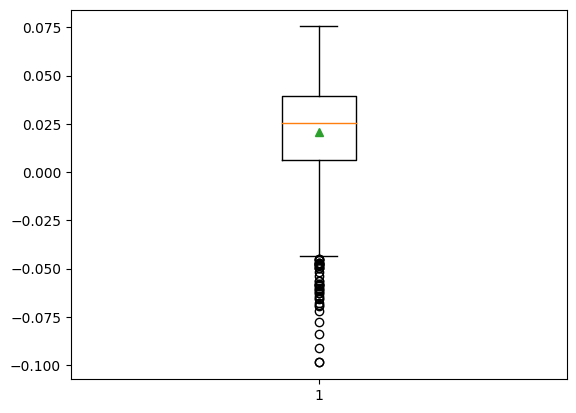

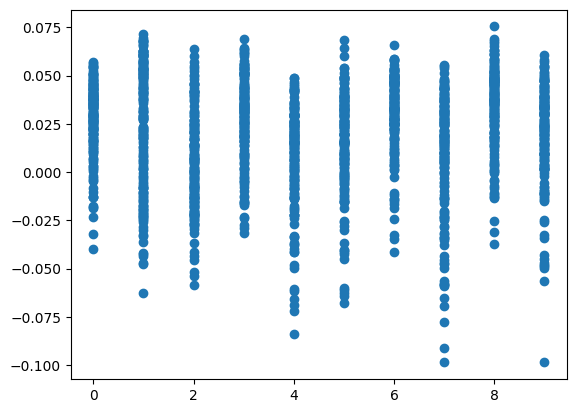

In [52]:
plt.boxplot(df['score'], showmeans=True, showfliers=True)
plt.show()

plt.scatter(df['label'], df['score'])
plt.show()